In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm

import sys
# sys.path.append('../../')

from util import *
from model.pinn import PINNs
from model.pinnsformer_Fourier import PINNsformer

In [2]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# device = 'cuda:0'
device = torch.device("mps")
# device = 'cpu'

In [3]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 51, 51)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = make_time_sequence(res, num_step=5, step=1e-4)
b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [4]:
model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

/var/folders/g1/hdxl9hhd6tqb8195x22dzx040000gn/T/ipykernel_14680/1725142899.py:25: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

In [5]:
loss_track = []

for i in tqdm(range(500)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

    if (i + 1) % 1 == 0:
        last_res, last_bc, last_ic = loss_track[-1]
        total = last_res + last_bc + last_ic
        print(f"Epoch {i+1:4d} | Total Loss: {total:.4e} | Res: {last_res:.4e} | BC: {last_bc:.4e} | IC: {last_ic:.4e}")

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:06<57:52,  6.96s/it]

Epoch    1 | Total Loss: 2.2829e-01 | Res: 2.1603e-02 | BC: 0.0000e+00 | IC: 2.0668e-01


  0%|          | 2/500 [00:13<55:40,  6.71s/it]

Epoch    2 | Total Loss: 1.9409e-01 | Res: 2.0092e-02 | BC: 0.0000e+00 | IC: 1.7400e-01


  1%|          | 3/500 [00:19<54:20,  6.56s/it]

Epoch    3 | Total Loss: 1.7660e-01 | Res: 2.5433e-02 | BC: 0.0000e+00 | IC: 1.5117e-01


  1%|          | 4/500 [00:26<55:19,  6.69s/it]

Epoch    4 | Total Loss: 1.5571e-01 | Res: 2.3756e-02 | BC: 0.0000e+00 | IC: 1.3195e-01


  1%|          | 5/500 [00:34<58:10,  7.05s/it]

Epoch    5 | Total Loss: 1.3031e-01 | Res: 2.3065e-02 | BC: 0.0000e+00 | IC: 1.0725e-01


  1%|          | 6/500 [00:41<59:25,  7.22s/it]

Epoch    6 | Total Loss: 1.1262e-01 | Res: 2.2055e-02 | BC: 0.0000e+00 | IC: 9.0564e-02


  1%|▏         | 7/500 [00:49<1:01:00,  7.43s/it]

Epoch    7 | Total Loss: 1.0680e-01 | Res: 1.9831e-02 | BC: 0.0000e+00 | IC: 8.6968e-02


  2%|▏         | 8/500 [00:57<1:00:27,  7.37s/it]

Epoch    8 | Total Loss: 1.0170e-01 | Res: 2.1331e-02 | BC: 0.0000e+00 | IC: 8.0367e-02


  2%|▏         | 9/500 [01:04<1:00:50,  7.44s/it]

Epoch    9 | Total Loss: 9.4754e-02 | Res: 2.1779e-02 | BC: 0.0000e+00 | IC: 7.2975e-02


  2%|▏         | 10/500 [01:12<1:01:48,  7.57s/it]

Epoch   10 | Total Loss: 8.7608e-02 | Res: 1.8138e-02 | BC: 0.0000e+00 | IC: 6.9470e-02


  2%|▏         | 11/500 [01:20<1:01:39,  7.57s/it]

Epoch   11 | Total Loss: 7.6458e-02 | Res: 3.3957e-02 | BC: 0.0000e+00 | IC: 4.2501e-02


  2%|▏         | 12/500 [01:27<1:02:14,  7.65s/it]

Epoch   12 | Total Loss: 5.8792e-02 | Res: 3.3912e-02 | BC: 0.0000e+00 | IC: 2.4880e-02


  3%|▎         | 13/500 [01:35<1:01:11,  7.54s/it]

Epoch   13 | Total Loss: 5.2996e-02 | Res: 2.9079e-02 | BC: 0.0000e+00 | IC: 2.3917e-02


  3%|▎         | 14/500 [01:42<1:00:17,  7.44s/it]

Epoch   14 | Total Loss: 4.7289e-02 | Res: 2.9709e-02 | BC: 0.0000e+00 | IC: 1.7580e-02


  3%|▎         | 15/500 [01:50<1:00:50,  7.53s/it]

Epoch   15 | Total Loss: 4.2165e-02 | Res: 2.3047e-02 | BC: 0.0000e+00 | IC: 1.9118e-02


  3%|▎         | 16/500 [01:57<1:00:15,  7.47s/it]

Epoch   16 | Total Loss: 3.8142e-02 | Res: 1.9455e-02 | BC: 0.0000e+00 | IC: 1.8687e-02


  3%|▎         | 17/500 [02:04<59:46,  7.42s/it]  

Epoch   17 | Total Loss: 3.3541e-02 | Res: 1.8199e-02 | BC: 0.0000e+00 | IC: 1.5341e-02


  4%|▎         | 18/500 [02:12<1:01:08,  7.61s/it]

Epoch   18 | Total Loss: 2.9128e-02 | Res: 1.7752e-02 | BC: 0.0000e+00 | IC: 1.1376e-02


  4%|▍         | 19/500 [02:20<1:00:20,  7.53s/it]

Epoch   19 | Total Loss: 2.5926e-02 | Res: 1.4795e-02 | BC: 0.0000e+00 | IC: 1.1131e-02


  4%|▍         | 20/500 [02:27<59:41,  7.46s/it]  

Epoch   20 | Total Loss: 2.0546e-02 | Res: 1.2819e-02 | BC: 0.0000e+00 | IC: 7.7269e-03


  4%|▍         | 21/500 [02:34<58:28,  7.32s/it]

Epoch   21 | Total Loss: 1.7992e-02 | Res: 1.1857e-02 | BC: 0.0000e+00 | IC: 6.1342e-03


  4%|▍         | 22/500 [02:41<57:34,  7.23s/it]

Epoch   22 | Total Loss: 1.6199e-02 | Res: 1.1101e-02 | BC: 0.0000e+00 | IC: 5.0981e-03


  5%|▍         | 23/500 [02:48<56:55,  7.16s/it]

Epoch   23 | Total Loss: 1.5483e-02 | Res: 1.0404e-02 | BC: 0.0000e+00 | IC: 5.0788e-03


  5%|▍         | 24/500 [02:55<57:05,  7.20s/it]

Epoch   24 | Total Loss: 1.4438e-02 | Res: 9.4924e-03 | BC: 0.0000e+00 | IC: 4.9454e-03


  5%|▌         | 25/500 [03:02<56:29,  7.14s/it]

Epoch   25 | Total Loss: 1.3611e-02 | Res: 8.6270e-03 | BC: 0.0000e+00 | IC: 4.9843e-03


  5%|▌         | 26/500 [03:10<57:28,  7.27s/it]

Epoch   26 | Total Loss: 1.1669e-02 | Res: 8.1923e-03 | BC: 0.0000e+00 | IC: 3.4767e-03


  5%|▌         | 27/500 [03:17<56:42,  7.19s/it]

Epoch   27 | Total Loss: 1.0342e-02 | Res: 7.6581e-03 | BC: 0.0000e+00 | IC: 2.6840e-03


  6%|▌         | 28/500 [03:24<56:10,  7.14s/it]

Epoch   28 | Total Loss: 9.3059e-03 | Res: 6.4537e-03 | BC: 0.0000e+00 | IC: 2.8522e-03


  6%|▌         | 29/500 [03:32<57:07,  7.28s/it]

Epoch   29 | Total Loss: 8.2020e-03 | Res: 5.5055e-03 | BC: 0.0000e+00 | IC: 2.6965e-03


  6%|▌         | 30/500 [03:39<56:21,  7.20s/it]

Epoch   30 | Total Loss: 7.3186e-03 | Res: 5.2802e-03 | BC: 0.0000e+00 | IC: 2.0383e-03


  6%|▌         | 31/500 [03:46<56:30,  7.23s/it]

Epoch   31 | Total Loss: 6.1748e-03 | Res: 4.8761e-03 | BC: 0.0000e+00 | IC: 1.2987e-03


  6%|▋         | 32/500 [03:53<56:33,  7.25s/it]

Epoch   32 | Total Loss: 5.2252e-03 | Res: 4.3443e-03 | BC: 0.0000e+00 | IC: 8.8096e-04


  7%|▋         | 33/500 [04:00<55:52,  7.18s/it]

Epoch   33 | Total Loss: 4.5075e-03 | Res: 3.8783e-03 | BC: 0.0000e+00 | IC: 6.2915e-04


  7%|▋         | 34/500 [04:07<55:20,  7.13s/it]

Epoch   34 | Total Loss: 4.1144e-03 | Res: 3.5600e-03 | BC: 0.0000e+00 | IC: 5.5437e-04


  7%|▋         | 35/500 [04:14<54:57,  7.09s/it]

Epoch   35 | Total Loss: 3.5498e-03 | Res: 3.0853e-03 | BC: 0.0000e+00 | IC: 4.6449e-04


  7%|▋         | 36/500 [04:21<54:38,  7.07s/it]

Epoch   36 | Total Loss: 3.1232e-03 | Res: 2.7718e-03 | BC: 0.0000e+00 | IC: 3.5143e-04


  7%|▋         | 37/500 [04:28<54:24,  7.05s/it]

Epoch   37 | Total Loss: 2.8064e-03 | Res: 2.4481e-03 | BC: 0.0000e+00 | IC: 3.5837e-04


  8%|▊         | 38/500 [04:35<54:11,  7.04s/it]

Epoch   38 | Total Loss: 2.5593e-03 | Res: 2.2079e-03 | BC: 0.0000e+00 | IC: 3.5137e-04


  8%|▊         | 39/500 [04:42<54:01,  7.03s/it]

Epoch   39 | Total Loss: 2.3556e-03 | Res: 2.0332e-03 | BC: 0.0000e+00 | IC: 3.2241e-04


  8%|▊         | 40/500 [04:49<53:51,  7.02s/it]

Epoch   40 | Total Loss: 2.1572e-03 | Res: 1.8919e-03 | BC: 0.0000e+00 | IC: 2.6531e-04


  8%|▊         | 41/500 [04:56<53:43,  7.02s/it]

Epoch   41 | Total Loss: 2.0464e-03 | Res: 1.7396e-03 | BC: 0.0000e+00 | IC: 3.0680e-04


  8%|▊         | 42/500 [05:04<54:14,  7.11s/it]

Epoch   42 | Total Loss: 1.8278e-03 | Res: 1.5256e-03 | BC: 0.0000e+00 | IC: 3.0218e-04


  9%|▊         | 43/500 [05:11<54:36,  7.17s/it]

Epoch   43 | Total Loss: 1.6838e-03 | Res: 1.4092e-03 | BC: 0.0000e+00 | IC: 2.7454e-04


  9%|▉         | 44/500 [05:18<54:08,  7.12s/it]

Epoch   44 | Total Loss: 1.5685e-03 | Res: 1.3405e-03 | BC: 0.0000e+00 | IC: 2.2801e-04


  9%|▉         | 45/500 [05:25<53:45,  7.09s/it]

Epoch   45 | Total Loss: 1.4908e-03 | Res: 1.2667e-03 | BC: 0.0000e+00 | IC: 2.2414e-04


  9%|▉         | 46/500 [05:32<53:26,  7.06s/it]

Epoch   46 | Total Loss: 1.3148e-03 | Res: 1.1111e-03 | BC: 0.0000e+00 | IC: 2.0368e-04


  9%|▉         | 47/500 [05:39<53:13,  7.05s/it]

Epoch   47 | Total Loss: 1.2413e-03 | Res: 1.0209e-03 | BC: 0.0000e+00 | IC: 2.2038e-04


 10%|▉         | 48/500 [05:47<56:23,  7.49s/it]

Epoch   48 | Total Loss: 1.0878e-03 | Res: 9.1449e-04 | BC: 0.0000e+00 | IC: 1.7334e-04


 10%|▉         | 49/500 [05:55<56:32,  7.52s/it]

Epoch   49 | Total Loss: 1.0080e-03 | Res: 8.5044e-04 | BC: 0.0000e+00 | IC: 1.5756e-04


 10%|█         | 50/500 [06:02<55:16,  7.37s/it]

Epoch   50 | Total Loss: 9.0209e-04 | Res: 7.4276e-04 | BC: 0.0000e+00 | IC: 1.5932e-04


 10%|█         | 51/500 [06:09<54:21,  7.26s/it]

Epoch   51 | Total Loss: 8.5000e-04 | Res: 7.0738e-04 | BC: 0.0000e+00 | IC: 1.4262e-04


 10%|█         | 52/500 [06:16<53:40,  7.19s/it]

Epoch   52 | Total Loss: 7.7459e-04 | Res: 6.3889e-04 | BC: 0.0000e+00 | IC: 1.3570e-04


 11%|█         | 53/500 [06:23<53:11,  7.14s/it]

Epoch   53 | Total Loss: 7.2873e-04 | Res: 5.9549e-04 | BC: 0.0000e+00 | IC: 1.3324e-04


 11%|█         | 54/500 [06:30<53:28,  7.19s/it]

Epoch   54 | Total Loss: 6.7865e-04 | Res: 5.5196e-04 | BC: 0.0000e+00 | IC: 1.2669e-04


 11%|█         | 55/500 [06:38<53:38,  7.23s/it]

Epoch   55 | Total Loss: 6.6005e-04 | Res: 5.3605e-04 | BC: 0.0000e+00 | IC: 1.2401e-04


 11%|█         | 56/500 [06:45<53:01,  7.17s/it]

Epoch   56 | Total Loss: 6.1788e-04 | Res: 4.9782e-04 | BC: 0.0000e+00 | IC: 1.2006e-04


 11%|█▏        | 57/500 [06:52<53:14,  7.21s/it]

Epoch   57 | Total Loss: 5.9382e-04 | Res: 4.7508e-04 | BC: 0.0000e+00 | IC: 1.1874e-04


 12%|█▏        | 58/500 [06:59<53:23,  7.25s/it]

Epoch   58 | Total Loss: 5.6584e-04 | Res: 4.4506e-04 | BC: 0.0000e+00 | IC: 1.2078e-04


 12%|█▏        | 59/500 [07:06<52:47,  7.18s/it]

Epoch   59 | Total Loss: 5.4268e-04 | Res: 4.2603e-04 | BC: 0.0000e+00 | IC: 1.1664e-04


 12%|█▏        | 60/500 [07:14<52:59,  7.23s/it]

Epoch   60 | Total Loss: 5.1948e-04 | Res: 4.0633e-04 | BC: 0.0000e+00 | IC: 1.1315e-04


 12%|█▏        | 61/500 [07:21<53:06,  7.26s/it]

Epoch   61 | Total Loss: 4.8981e-04 | Res: 3.7923e-04 | BC: 0.0000e+00 | IC: 1.1058e-04


 12%|█▏        | 62/500 [07:28<53:08,  7.28s/it]

Epoch   62 | Total Loss: 4.7773e-04 | Res: 3.6850e-04 | BC: 0.0000e+00 | IC: 1.0923e-04


 13%|█▎        | 63/500 [07:36<53:05,  7.29s/it]

Epoch   63 | Total Loss: 4.5890e-04 | Res: 3.5034e-04 | BC: 0.0000e+00 | IC: 1.0856e-04


 13%|█▎        | 64/500 [07:43<53:02,  7.30s/it]

Epoch   64 | Total Loss: 4.2110e-04 | Res: 3.0188e-04 | BC: 0.0000e+00 | IC: 1.1922e-04


 13%|█▎        | 65/500 [07:50<52:57,  7.30s/it]

Epoch   65 | Total Loss: 4.0776e-04 | Res: 2.8500e-04 | BC: 0.0000e+00 | IC: 1.2276e-04


 13%|█▎        | 66/500 [07:58<52:54,  7.32s/it]

Epoch   66 | Total Loss: 3.9686e-04 | Res: 2.7138e-04 | BC: 0.0000e+00 | IC: 1.2548e-04


 13%|█▎        | 67/500 [08:05<52:09,  7.23s/it]

Epoch   67 | Total Loss: 3.7498e-04 | Res: 2.4207e-04 | BC: 0.0000e+00 | IC: 1.3290e-04


 14%|█▎        | 68/500 [08:12<51:35,  7.17s/it]

Epoch   68 | Total Loss: 3.6195e-04 | Res: 2.3184e-04 | BC: 0.0000e+00 | IC: 1.3011e-04


 14%|█▍        | 69/500 [08:19<52:27,  7.30s/it]

Epoch   69 | Total Loss: 3.4029e-04 | Res: 2.1404e-04 | BC: 0.0000e+00 | IC: 1.2625e-04


 14%|█▍        | 70/500 [08:26<51:44,  7.22s/it]

Epoch   70 | Total Loss: 3.2225e-04 | Res: 1.9412e-04 | BC: 0.0000e+00 | IC: 1.2812e-04


 14%|█▍        | 71/500 [08:33<51:12,  7.16s/it]

Epoch   71 | Total Loss: 3.1881e-04 | Res: 1.9070e-04 | BC: 0.0000e+00 | IC: 1.2811e-04


 14%|█▍        | 72/500 [08:41<51:26,  7.21s/it]

Epoch   72 | Total Loss: 3.0947e-04 | Res: 1.8260e-04 | BC: 0.0000e+00 | IC: 1.2687e-04


 15%|█▍        | 73/500 [08:48<50:54,  7.15s/it]

Epoch   73 | Total Loss: 2.9219e-04 | Res: 1.7407e-04 | BC: 0.0000e+00 | IC: 1.1812e-04


 15%|█▍        | 74/500 [08:55<51:08,  7.20s/it]

Epoch   74 | Total Loss: 2.8629e-04 | Res: 1.6878e-04 | BC: 0.0000e+00 | IC: 1.1751e-04


 15%|█▌        | 75/500 [09:02<51:17,  7.24s/it]

Epoch   75 | Total Loss: 2.7581e-04 | Res: 1.6023e-04 | BC: 0.0000e+00 | IC: 1.1558e-04


 15%|█▌        | 76/500 [09:10<51:20,  7.26s/it]

Epoch   76 | Total Loss: 2.7308e-04 | Res: 1.5698e-04 | BC: 0.0000e+00 | IC: 1.1610e-04


 15%|█▌        | 77/500 [09:17<51:18,  7.28s/it]

Epoch   77 | Total Loss: 2.6218e-04 | Res: 1.5025e-04 | BC: 0.0000e+00 | IC: 1.1193e-04


 16%|█▌        | 78/500 [09:24<51:19,  7.30s/it]

Epoch   78 | Total Loss: 2.4788e-04 | Res: 1.3799e-04 | BC: 0.0000e+00 | IC: 1.0989e-04


 16%|█▌        | 79/500 [09:31<50:37,  7.21s/it]

Epoch   79 | Total Loss: 2.4176e-04 | Res: 1.3520e-04 | BC: 0.0000e+00 | IC: 1.0656e-04


 16%|█▌        | 80/500 [09:39<50:42,  7.25s/it]

Epoch   80 | Total Loss: 2.3738e-04 | Res: 1.3409e-04 | BC: 0.0000e+00 | IC: 1.0329e-04


 16%|█▌        | 81/500 [09:46<50:45,  7.27s/it]

Epoch   81 | Total Loss: 2.2803e-04 | Res: 1.3014e-04 | BC: 0.0000e+00 | IC: 9.7890e-05


 16%|█▋        | 82/500 [09:53<50:08,  7.20s/it]

Epoch   82 | Total Loss: 2.2288e-04 | Res: 1.2654e-04 | BC: 0.0000e+00 | IC: 9.6342e-05


 17%|█▋        | 83/500 [10:01<50:54,  7.33s/it]

Epoch   83 | Total Loss: 2.1332e-04 | Res: 1.2256e-04 | BC: 0.0000e+00 | IC: 9.0759e-05


 17%|█▋        | 84/500 [10:08<50:46,  7.32s/it]

Epoch   84 | Total Loss: 2.0620e-04 | Res: 1.1803e-04 | BC: 0.0000e+00 | IC: 8.8171e-05


 17%|█▋        | 85/500 [10:15<50:38,  7.32s/it]

Epoch   85 | Total Loss: 2.0183e-04 | Res: 1.1338e-04 | BC: 0.0000e+00 | IC: 8.8454e-05


 17%|█▋        | 86/500 [10:22<49:53,  7.23s/it]

Epoch   86 | Total Loss: 1.9637e-04 | Res: 1.1107e-04 | BC: 0.0000e+00 | IC: 8.5308e-05


 17%|█▋        | 87/500 [10:30<49:57,  7.26s/it]

Epoch   87 | Total Loss: 1.9136e-04 | Res: 1.0555e-04 | BC: 0.0000e+00 | IC: 8.5809e-05


 18%|█▊        | 88/500 [10:37<49:56,  7.27s/it]

Epoch   88 | Total Loss: 1.8528e-04 | Res: 1.0150e-04 | BC: 0.0000e+00 | IC: 8.3779e-05


 18%|█▊        | 89/500 [10:44<49:55,  7.29s/it]

Epoch   89 | Total Loss: 1.8107e-04 | Res: 9.8826e-05 | BC: 0.0000e+00 | IC: 8.2248e-05


 18%|█▊        | 90/500 [10:52<49:51,  7.30s/it]

Epoch   90 | Total Loss: 1.7684e-04 | Res: 9.8671e-05 | BC: 0.0000e+00 | IC: 7.8172e-05


 18%|█▊        | 91/500 [10:59<50:25,  7.40s/it]

Epoch   91 | Total Loss: 1.7330e-04 | Res: 9.9060e-05 | BC: 0.0000e+00 | IC: 7.4236e-05


 18%|█▊        | 92/500 [11:06<49:31,  7.28s/it]

Epoch   92 | Total Loss: 1.6862e-04 | Res: 9.8802e-05 | BC: 0.0000e+00 | IC: 6.9818e-05


 19%|█▊        | 93/500 [11:14<49:28,  7.29s/it]

Epoch   93 | Total Loss: 1.6631e-04 | Res: 9.8462e-05 | BC: 0.0000e+00 | IC: 6.7851e-05


 19%|█▉        | 94/500 [11:21<49:22,  7.30s/it]

Epoch   94 | Total Loss: 1.6469e-04 | Res: 9.7306e-05 | BC: 0.0000e+00 | IC: 6.7388e-05


 19%|█▉        | 95/500 [11:28<49:17,  7.30s/it]

Epoch   95 | Total Loss: 1.5923e-04 | Res: 9.2448e-05 | BC: 0.0000e+00 | IC: 6.6779e-05


 19%|█▉        | 96/500 [11:35<48:33,  7.21s/it]

Epoch   96 | Total Loss: 1.5511e-04 | Res: 8.8722e-05 | BC: 0.0000e+00 | IC: 6.6390e-05


 19%|█▉        | 97/500 [11:43<48:39,  7.24s/it]

Epoch   97 | Total Loss: 1.5155e-04 | Res: 8.7644e-05 | BC: 0.0000e+00 | IC: 6.3906e-05


 20%|█▉        | 98/500 [11:50<49:15,  7.35s/it]

Epoch   98 | Total Loss: 1.4901e-04 | Res: 8.4810e-05 | BC: 0.0000e+00 | IC: 6.4198e-05


 20%|█▉        | 99/500 [11:57<49:03,  7.34s/it]

Epoch   99 | Total Loss: 1.4750e-04 | Res: 8.3626e-05 | BC: 0.0000e+00 | IC: 6.3870e-05


 20%|██        | 100/500 [12:04<48:16,  7.24s/it]

Epoch  100 | Total Loss: 1.4589e-04 | Res: 8.3159e-05 | BC: 0.0000e+00 | IC: 6.2727e-05


 20%|██        | 101/500 [12:12<49:27,  7.44s/it]

Epoch  101 | Total Loss: 1.4296e-04 | Res: 8.1149e-05 | BC: 0.0000e+00 | IC: 6.1811e-05


 20%|██        | 102/500 [12:20<49:03,  7.40s/it]

Epoch  102 | Total Loss: 1.3981e-04 | Res: 7.7029e-05 | BC: 0.0000e+00 | IC: 6.2778e-05


 21%|██        | 103/500 [12:27<48:47,  7.37s/it]

Epoch  103 | Total Loss: 1.3578e-04 | Res: 7.5389e-05 | BC: 0.0000e+00 | IC: 6.0396e-05


 21%|██        | 104/500 [12:35<49:40,  7.53s/it]

Epoch  104 | Total Loss: 1.3394e-04 | Res: 7.6922e-05 | BC: 0.0000e+00 | IC: 5.7022e-05


 21%|██        | 105/500 [12:42<48:31,  7.37s/it]

Epoch  105 | Total Loss: 1.3240e-04 | Res: 7.7766e-05 | BC: 0.0000e+00 | IC: 5.4636e-05


 21%|██        | 106/500 [12:49<48:15,  7.35s/it]

Epoch  106 | Total Loss: 1.3037e-04 | Res: 7.8364e-05 | BC: 0.0000e+00 | IC: 5.2005e-05


 21%|██▏       | 107/500 [12:56<48:04,  7.34s/it]

Epoch  107 | Total Loss: 1.2868e-04 | Res: 7.6786e-05 | BC: 0.0000e+00 | IC: 5.1889e-05


 22%|██▏       | 108/500 [13:04<47:53,  7.33s/it]

Epoch  108 | Total Loss: 1.2725e-04 | Res: 7.6345e-05 | BC: 0.0000e+00 | IC: 5.0904e-05


 22%|██▏       | 109/500 [13:11<47:43,  7.32s/it]

Epoch  109 | Total Loss: 1.2544e-04 | Res: 7.3691e-05 | BC: 0.0000e+00 | IC: 5.1746e-05


 22%|██▏       | 110/500 [13:18<47:00,  7.23s/it]

Epoch  110 | Total Loss: 1.2302e-04 | Res: 6.9924e-05 | BC: 0.0000e+00 | IC: 5.3095e-05


 22%|██▏       | 111/500 [13:25<46:27,  7.16s/it]

Epoch  111 | Total Loss: 1.2009e-04 | Res: 6.7171e-05 | BC: 0.0000e+00 | IC: 5.2921e-05


 22%|██▏       | 112/500 [13:32<46:35,  7.21s/it]

Epoch  112 | Total Loss: 1.1834e-04 | Res: 6.6442e-05 | BC: 0.0000e+00 | IC: 5.1897e-05


 23%|██▎       | 113/500 [13:40<46:40,  7.24s/it]

Epoch  113 | Total Loss: 1.1737e-04 | Res: 6.6515e-05 | BC: 0.0000e+00 | IC: 5.0853e-05


 23%|██▎       | 114/500 [13:47<46:05,  7.16s/it]

Epoch  114 | Total Loss: 1.1620e-04 | Res: 6.5091e-05 | BC: 0.0000e+00 | IC: 5.1113e-05


 23%|██▎       | 115/500 [13:54<46:49,  7.30s/it]

Epoch  115 | Total Loss: 1.1460e-04 | Res: 6.3674e-05 | BC: 0.0000e+00 | IC: 5.0925e-05


 23%|██▎       | 116/500 [14:01<46:08,  7.21s/it]

Epoch  116 | Total Loss: 1.1078e-04 | Res: 6.1473e-05 | BC: 0.0000e+00 | IC: 4.9311e-05


 23%|██▎       | 117/500 [14:09<46:44,  7.32s/it]

Epoch  117 | Total Loss: 1.0838e-04 | Res: 6.2915e-05 | BC: 0.0000e+00 | IC: 4.5463e-05


 24%|██▎       | 118/500 [14:16<46:36,  7.32s/it]

Epoch  118 | Total Loss: 1.0676e-04 | Res: 6.3629e-05 | BC: 0.0000e+00 | IC: 4.3136e-05


 24%|██▍       | 119/500 [14:24<46:27,  7.32s/it]

Epoch  119 | Total Loss: 1.0467e-04 | Res: 6.1315e-05 | BC: 0.0000e+00 | IC: 4.3353e-05


 24%|██▍       | 120/500 [14:31<46:51,  7.40s/it]

Epoch  120 | Total Loss: 1.0253e-04 | Res: 5.8298e-05 | BC: 0.0000e+00 | IC: 4.4237e-05


 24%|██▍       | 121/500 [14:38<46:00,  7.28s/it]

Epoch  121 | Total Loss: 1.0058e-04 | Res: 5.7890e-05 | BC: 0.0000e+00 | IC: 4.2685e-05


 24%|██▍       | 122/500 [14:45<45:22,  7.20s/it]

Epoch  122 | Total Loss: 9.7678e-05 | Res: 5.7807e-05 | BC: 0.0000e+00 | IC: 3.9870e-05


 25%|██▍       | 123/500 [14:52<44:53,  7.14s/it]

Epoch  123 | Total Loss: 9.4493e-05 | Res: 5.2844e-05 | BC: 0.0000e+00 | IC: 4.1649e-05


 25%|██▍       | 124/500 [15:00<45:37,  7.28s/it]

Epoch  124 | Total Loss: 9.2960e-05 | Res: 5.2359e-05 | BC: 0.0000e+00 | IC: 4.0601e-05


 25%|██▌       | 125/500 [15:07<45:34,  7.29s/it]

Epoch  125 | Total Loss: 9.1179e-05 | Res: 5.0511e-05 | BC: 0.0000e+00 | IC: 4.0668e-05


 25%|██▌       | 126/500 [15:14<44:55,  7.21s/it]

Epoch  126 | Total Loss: 8.9464e-05 | Res: 4.9536e-05 | BC: 0.0000e+00 | IC: 3.9928e-05


 25%|██▌       | 127/500 [15:22<45:32,  7.33s/it]

Epoch  127 | Total Loss: 8.7582e-05 | Res: 4.8629e-05 | BC: 0.0000e+00 | IC: 3.8952e-05


 26%|██▌       | 128/500 [15:29<45:55,  7.41s/it]

Epoch  128 | Total Loss: 8.5096e-05 | Res: 4.7819e-05 | BC: 0.0000e+00 | IC: 3.7277e-05


 26%|██▌       | 129/500 [15:36<45:04,  7.29s/it]

Epoch  129 | Total Loss: 8.2397e-05 | Res: 4.7398e-05 | BC: 0.0000e+00 | IC: 3.4999e-05


 26%|██▌       | 130/500 [15:43<44:26,  7.21s/it]

Epoch  130 | Total Loss: 7.9125e-05 | Res: 4.7068e-05 | BC: 0.0000e+00 | IC: 3.2057e-05


 26%|██▌       | 131/500 [15:50<43:57,  7.15s/it]

Epoch  131 | Total Loss: 7.5580e-05 | Res: 4.5605e-05 | BC: 0.0000e+00 | IC: 2.9975e-05


 26%|██▋       | 132/500 [15:58<44:07,  7.19s/it]

Epoch  132 | Total Loss: 7.3655e-05 | Res: 4.3791e-05 | BC: 0.0000e+00 | IC: 2.9864e-05


 27%|██▋       | 133/500 [16:05<43:40,  7.14s/it]

Epoch  133 | Total Loss: 7.1543e-05 | Res: 4.1482e-05 | BC: 0.0000e+00 | IC: 3.0061e-05


 27%|██▋       | 134/500 [16:12<44:25,  7.28s/it]

Epoch  134 | Total Loss: 7.0137e-05 | Res: 4.0649e-05 | BC: 0.0000e+00 | IC: 2.9489e-05


 27%|██▋       | 135/500 [16:20<44:21,  7.29s/it]

Epoch  135 | Total Loss: 6.8774e-05 | Res: 3.9691e-05 | BC: 0.0000e+00 | IC: 2.9083e-05


 27%|██▋       | 136/500 [16:27<44:15,  7.30s/it]

Epoch  136 | Total Loss: 6.7169e-05 | Res: 3.8128e-05 | BC: 0.0000e+00 | IC: 2.9041e-05


 27%|██▋       | 137/500 [16:34<44:08,  7.30s/it]

Epoch  137 | Total Loss: 6.5161e-05 | Res: 3.6472e-05 | BC: 0.0000e+00 | IC: 2.8689e-05


 28%|██▊       | 138/500 [16:41<44:01,  7.30s/it]

Epoch  138 | Total Loss: 6.4072e-05 | Res: 3.5341e-05 | BC: 0.0000e+00 | IC: 2.8731e-05


 28%|██▊       | 139/500 [16:49<44:29,  7.39s/it]

Epoch  139 | Total Loss: 6.3452e-05 | Res: 3.4827e-05 | BC: 0.0000e+00 | IC: 2.8625e-05


 28%|██▊       | 140/500 [16:56<43:42,  7.28s/it]

Epoch  140 | Total Loss: 6.2069e-05 | Res: 3.3167e-05 | BC: 0.0000e+00 | IC: 2.8902e-05


 28%|██▊       | 141/500 [17:03<43:05,  7.20s/it]

Epoch  141 | Total Loss: 6.0256e-05 | Res: 3.1194e-05 | BC: 0.0000e+00 | IC: 2.9062e-05


 28%|██▊       | 142/500 [17:10<43:10,  7.24s/it]

Epoch  142 | Total Loss: 5.8610e-05 | Res: 2.9967e-05 | BC: 0.0000e+00 | IC: 2.8643e-05


 29%|██▊       | 143/500 [17:18<43:11,  7.26s/it]

Epoch  143 | Total Loss: 5.5169e-05 | Res: 2.8821e-05 | BC: 0.0000e+00 | IC: 2.6348e-05


 29%|██▉       | 144/500 [17:25<42:36,  7.18s/it]

Epoch  144 | Total Loss: 5.3275e-05 | Res: 2.7482e-05 | BC: 0.0000e+00 | IC: 2.5793e-05


 29%|██▉       | 145/500 [17:32<42:42,  7.22s/it]

Epoch  145 | Total Loss: 5.2449e-05 | Res: 2.7241e-05 | BC: 0.0000e+00 | IC: 2.5208e-05


 29%|██▉       | 146/500 [17:40<43:15,  7.33s/it]

Epoch  146 | Total Loss: 5.1131e-05 | Res: 2.6170e-05 | BC: 0.0000e+00 | IC: 2.4961e-05


 29%|██▉       | 147/500 [17:47<43:04,  7.32s/it]

Epoch  147 | Total Loss: 5.0031e-05 | Res: 2.5942e-05 | BC: 0.0000e+00 | IC: 2.4088e-05


 30%|██▉       | 148/500 [17:54<42:38,  7.27s/it]

Epoch  148 | Total Loss: 4.9357e-05 | Res: 2.5948e-05 | BC: 0.0000e+00 | IC: 2.3408e-05


 30%|██▉       | 149/500 [18:02<43:09,  7.38s/it]

Epoch  149 | Total Loss: 4.7734e-05 | Res: 2.5128e-05 | BC: 0.0000e+00 | IC: 2.2606e-05


 30%|███       | 150/500 [18:09<42:23,  7.27s/it]

Epoch  150 | Total Loss: 4.6841e-05 | Res: 2.5228e-05 | BC: 0.0000e+00 | IC: 2.1613e-05


 30%|███       | 151/500 [18:16<41:48,  7.19s/it]

Epoch  151 | Total Loss: 4.5892e-05 | Res: 2.4610e-05 | BC: 0.0000e+00 | IC: 2.1282e-05


 30%|███       | 152/500 [18:23<41:21,  7.13s/it]

Epoch  152 | Total Loss: 4.4980e-05 | Res: 2.4110e-05 | BC: 0.0000e+00 | IC: 2.0869e-05


 31%|███       | 153/500 [18:30<41:46,  7.22s/it]

Epoch  153 | Total Loss: 4.3578e-05 | Res: 2.3278e-05 | BC: 0.0000e+00 | IC: 2.0300e-05


 31%|███       | 154/500 [18:38<41:48,  7.25s/it]

Epoch  154 | Total Loss: 4.2500e-05 | Res: 2.2777e-05 | BC: 0.0000e+00 | IC: 1.9723e-05


 31%|███       | 155/500 [18:45<41:48,  7.27s/it]

Epoch  155 | Total Loss: 4.1985e-05 | Res: 2.2429e-05 | BC: 0.0000e+00 | IC: 1.9556e-05


 31%|███       | 156/500 [18:52<42:15,  7.37s/it]

Epoch  156 | Total Loss: 4.1455e-05 | Res: 2.2066e-05 | BC: 0.0000e+00 | IC: 1.9389e-05


 31%|███▏      | 157/500 [19:00<42:12,  7.38s/it]

Epoch  157 | Total Loss: 4.0119e-05 | Res: 2.2112e-05 | BC: 0.0000e+00 | IC: 1.8007e-05


 32%|███▏      | 158/500 [19:07<41:32,  7.29s/it]

Epoch  158 | Total Loss: 3.8482e-05 | Res: 2.1195e-05 | BC: 0.0000e+00 | IC: 1.7287e-05


 32%|███▏      | 159/500 [19:15<42:11,  7.42s/it]

Epoch  159 | Total Loss: 3.7479e-05 | Res: 2.1365e-05 | BC: 0.0000e+00 | IC: 1.6114e-05


 32%|███▏      | 160/500 [19:22<42:05,  7.43s/it]

Epoch  160 | Total Loss: 3.7117e-05 | Res: 2.1503e-05 | BC: 0.0000e+00 | IC: 1.5614e-05


 32%|███▏      | 161/500 [19:29<41:18,  7.31s/it]

Epoch  161 | Total Loss: 3.6632e-05 | Res: 2.1355e-05 | BC: 0.0000e+00 | IC: 1.5277e-05


 32%|███▏      | 162/500 [19:36<41:09,  7.31s/it]

Epoch  162 | Total Loss: 3.5905e-05 | Res: 2.1629e-05 | BC: 0.0000e+00 | IC: 1.4276e-05


 33%|███▎      | 163/500 [19:44<42:01,  7.48s/it]

Epoch  163 | Total Loss: 3.5421e-05 | Res: 2.1395e-05 | BC: 0.0000e+00 | IC: 1.4027e-05


 33%|███▎      | 164/500 [19:52<41:36,  7.43s/it]

Epoch  164 | Total Loss: 3.4534e-05 | Res: 2.0625e-05 | BC: 0.0000e+00 | IC: 1.3910e-05


 33%|███▎      | 165/500 [19:59<40:46,  7.30s/it]

Epoch  165 | Total Loss: 3.3931e-05 | Res: 2.0326e-05 | BC: 0.0000e+00 | IC: 1.3606e-05


 33%|███▎      | 166/500 [20:06<40:07,  7.21s/it]

Epoch  166 | Total Loss: 3.3420e-05 | Res: 2.0008e-05 | BC: 0.0000e+00 | IC: 1.3412e-05


 33%|███▎      | 167/500 [20:13<40:09,  7.24s/it]

Epoch  167 | Total Loss: 3.2670e-05 | Res: 1.9634e-05 | BC: 0.0000e+00 | IC: 1.3036e-05


 34%|███▎      | 168/500 [20:20<39:38,  7.16s/it]

Epoch  168 | Total Loss: 3.2158e-05 | Res: 1.9856e-05 | BC: 0.0000e+00 | IC: 1.2302e-05


 34%|███▍      | 169/500 [20:27<39:13,  7.11s/it]

Epoch  169 | Total Loss: 3.1633e-05 | Res: 1.9880e-05 | BC: 0.0000e+00 | IC: 1.1753e-05


 34%|███▍      | 170/500 [20:35<39:54,  7.26s/it]

Epoch  170 | Total Loss: 3.1294e-05 | Res: 2.0115e-05 | BC: 0.0000e+00 | IC: 1.1179e-05


 34%|███▍      | 171/500 [20:42<39:22,  7.18s/it]

Epoch  171 | Total Loss: 3.0895e-05 | Res: 1.9937e-05 | BC: 0.0000e+00 | IC: 1.0958e-05


 34%|███▍      | 172/500 [20:49<39:27,  7.22s/it]

Epoch  172 | Total Loss: 3.0318e-05 | Res: 1.9659e-05 | BC: 0.0000e+00 | IC: 1.0658e-05


 35%|███▍      | 173/500 [20:56<39:27,  7.24s/it]

Epoch  173 | Total Loss: 2.9958e-05 | Res: 1.9394e-05 | BC: 0.0000e+00 | IC: 1.0563e-05


 35%|███▍      | 174/500 [21:04<39:55,  7.35s/it]

Epoch  174 | Total Loss: 2.9701e-05 | Res: 1.9393e-05 | BC: 0.0000e+00 | IC: 1.0308e-05


 35%|███▌      | 175/500 [21:11<39:44,  7.34s/it]

Epoch  175 | Total Loss: 2.9223e-05 | Res: 1.9473e-05 | BC: 0.0000e+00 | IC: 9.7494e-06


 35%|███▌      | 176/500 [21:18<39:32,  7.32s/it]

Epoch  176 | Total Loss: 2.8741e-05 | Res: 1.9236e-05 | BC: 0.0000e+00 | IC: 9.5047e-06


 35%|███▌      | 177/500 [21:25<38:55,  7.23s/it]

Epoch  177 | Total Loss: 2.8208e-05 | Res: 1.8715e-05 | BC: 0.0000e+00 | IC: 9.4935e-06


 36%|███▌      | 178/500 [21:33<38:53,  7.25s/it]

Epoch  178 | Total Loss: 2.7359e-05 | Res: 1.7758e-05 | BC: 0.0000e+00 | IC: 9.6009e-06


 36%|███▌      | 179/500 [21:40<38:22,  7.17s/it]

Epoch  179 | Total Loss: 2.6943e-05 | Res: 1.7741e-05 | BC: 0.0000e+00 | IC: 9.2020e-06


 36%|███▌      | 180/500 [21:47<37:59,  7.12s/it]

Epoch  180 | Total Loss: 2.6533e-05 | Res: 1.7790e-05 | BC: 0.0000e+00 | IC: 8.7426e-06


 36%|███▌      | 181/500 [21:54<37:40,  7.09s/it]

Epoch  181 | Total Loss: 2.6195e-05 | Res: 1.7841e-05 | BC: 0.0000e+00 | IC: 8.3533e-06


 36%|███▋      | 182/500 [22:01<37:27,  7.07s/it]

Epoch  182 | Total Loss: 2.5821e-05 | Res: 1.8314e-05 | BC: 0.0000e+00 | IC: 7.5073e-06


 37%|███▋      | 183/500 [22:08<37:42,  7.14s/it]

Epoch  183 | Total Loss: 2.5495e-05 | Res: 1.8162e-05 | BC: 0.0000e+00 | IC: 7.3336e-06


 37%|███▋      | 184/500 [22:15<37:48,  7.18s/it]

Epoch  184 | Total Loss: 2.5061e-05 | Res: 1.8177e-05 | BC: 0.0000e+00 | IC: 6.8834e-06


 37%|███▋      | 185/500 [22:23<37:53,  7.22s/it]

Epoch  185 | Total Loss: 2.4183e-05 | Res: 1.7790e-05 | BC: 0.0000e+00 | IC: 6.3933e-06


 37%|███▋      | 186/500 [22:30<38:22,  7.33s/it]

Epoch  186 | Total Loss: 2.3731e-05 | Res: 1.7545e-05 | BC: 0.0000e+00 | IC: 6.1860e-06


 37%|███▋      | 187/500 [22:38<38:39,  7.41s/it]

Epoch  187 | Total Loss: 2.3313e-05 | Res: 1.7134e-05 | BC: 0.0000e+00 | IC: 6.1791e-06


 38%|███▊      | 188/500 [22:45<38:19,  7.37s/it]

Epoch  188 | Total Loss: 2.2971e-05 | Res: 1.6748e-05 | BC: 0.0000e+00 | IC: 6.2226e-06


 38%|███▊      | 189/500 [22:52<37:37,  7.26s/it]

Epoch  189 | Total Loss: 2.2640e-05 | Res: 1.6657e-05 | BC: 0.0000e+00 | IC: 5.9826e-06


 38%|███▊      | 190/500 [22:59<37:07,  7.19s/it]

Epoch  190 | Total Loss: 2.2296e-05 | Res: 1.6369e-05 | BC: 0.0000e+00 | IC: 5.9262e-06


 38%|███▊      | 191/500 [23:07<38:06,  7.40s/it]

Epoch  191 | Total Loss: 2.1953e-05 | Res: 1.6022e-05 | BC: 0.0000e+00 | IC: 5.9312e-06


 38%|███▊      | 192/500 [23:14<37:23,  7.28s/it]

Epoch  192 | Total Loss: 2.1587e-05 | Res: 1.5883e-05 | BC: 0.0000e+00 | IC: 5.7042e-06


 39%|███▊      | 193/500 [23:21<37:16,  7.29s/it]

Epoch  193 | Total Loss: 2.1376e-05 | Res: 1.5541e-05 | BC: 0.0000e+00 | IC: 5.8341e-06


 39%|███▉      | 194/500 [23:29<37:11,  7.29s/it]

Epoch  194 | Total Loss: 2.1176e-05 | Res: 1.5504e-05 | BC: 0.0000e+00 | IC: 5.6720e-06


 39%|███▉      | 195/500 [23:36<38:00,  7.48s/it]

Epoch  195 | Total Loss: 2.0880e-05 | Res: 1.5475e-05 | BC: 0.0000e+00 | IC: 5.4057e-06


 39%|███▉      | 196/500 [23:44<38:04,  7.52s/it]

Epoch  196 | Total Loss: 2.0498e-05 | Res: 1.5376e-05 | BC: 0.0000e+00 | IC: 5.1228e-06


 39%|███▉      | 197/500 [23:51<37:10,  7.36s/it]

Epoch  197 | Total Loss: 1.9990e-05 | Res: 1.4986e-05 | BC: 0.0000e+00 | IC: 5.0041e-06


 40%|███▉      | 198/500 [23:59<37:27,  7.44s/it]

Epoch  198 | Total Loss: 1.9491e-05 | Res: 1.4602e-05 | BC: 0.0000e+00 | IC: 4.8888e-06


 40%|███▉      | 199/500 [24:06<37:08,  7.40s/it]

Epoch  199 | Total Loss: 1.9259e-05 | Res: 1.4368e-05 | BC: 0.0000e+00 | IC: 4.8915e-06


 40%|████      | 200/500 [24:13<36:24,  7.28s/it]

Epoch  200 | Total Loss: 1.8981e-05 | Res: 1.4134e-05 | BC: 0.0000e+00 | IC: 4.8478e-06


 40%|████      | 201/500 [24:21<36:45,  7.38s/it]

Epoch  201 | Total Loss: 1.8723e-05 | Res: 1.3843e-05 | BC: 0.0000e+00 | IC: 4.8793e-06


 40%|████      | 202/500 [24:28<36:31,  7.36s/it]

Epoch  202 | Total Loss: 1.8510e-05 | Res: 1.3634e-05 | BC: 0.0000e+00 | IC: 4.8759e-06


 41%|████      | 203/500 [24:35<36:20,  7.34s/it]

Epoch  203 | Total Loss: 1.8176e-05 | Res: 1.3192e-05 | BC: 0.0000e+00 | IC: 4.9835e-06


 41%|████      | 204/500 [24:42<35:43,  7.24s/it]

Epoch  204 | Total Loss: 1.7815e-05 | Res: 1.2957e-05 | BC: 0.0000e+00 | IC: 4.8583e-06


 41%|████      | 205/500 [24:50<36:08,  7.35s/it]

Epoch  205 | Total Loss: 1.7520e-05 | Res: 1.2672e-05 | BC: 0.0000e+00 | IC: 4.8477e-06


 41%|████      | 206/500 [24:57<35:31,  7.25s/it]

Epoch  206 | Total Loss: 1.7143e-05 | Res: 1.2406e-05 | BC: 0.0000e+00 | IC: 4.7376e-06


 41%|████▏     | 207/500 [25:04<35:02,  7.18s/it]

Epoch  207 | Total Loss: 1.6934e-05 | Res: 1.2220e-05 | BC: 0.0000e+00 | IC: 4.7140e-06


 42%|████▏     | 208/500 [25:11<35:07,  7.22s/it]

Epoch  208 | Total Loss: 1.6667e-05 | Res: 1.2022e-05 | BC: 0.0000e+00 | IC: 4.6455e-06


 42%|████▏     | 209/500 [25:18<34:40,  7.15s/it]

Epoch  209 | Total Loss: 1.6415e-05 | Res: 1.1792e-05 | BC: 0.0000e+00 | IC: 4.6233e-06


 42%|████▏     | 210/500 [25:25<34:46,  7.19s/it]

Epoch  210 | Total Loss: 1.5974e-05 | Res: 1.1251e-05 | BC: 0.0000e+00 | IC: 4.7227e-06


 42%|████▏     | 211/500 [25:33<35:24,  7.35s/it]

Epoch  211 | Total Loss: 1.5632e-05 | Res: 1.0985e-05 | BC: 0.0000e+00 | IC: 4.6464e-06


 42%|████▏     | 212/500 [25:41<35:40,  7.43s/it]

Epoch  212 | Total Loss: 1.5253e-05 | Res: 1.0734e-05 | BC: 0.0000e+00 | IC: 4.5186e-06


 43%|████▎     | 213/500 [25:49<36:56,  7.72s/it]

Epoch  213 | Total Loss: 1.5043e-05 | Res: 1.0598e-05 | BC: 0.0000e+00 | IC: 4.4452e-06


 43%|████▎     | 214/500 [25:56<36:12,  7.60s/it]

Epoch  214 | Total Loss: 1.4829e-05 | Res: 1.0531e-05 | BC: 0.0000e+00 | IC: 4.2980e-06


 43%|████▎     | 215/500 [26:04<35:40,  7.51s/it]

Epoch  215 | Total Loss: 1.4697e-05 | Res: 1.0377e-05 | BC: 0.0000e+00 | IC: 4.3199e-06


 43%|████▎     | 216/500 [26:08<30:15,  6.39s/it]

Epoch  216 | Total Loss: 1.4676e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3169e-06


 43%|████▎     | 217/500 [26:10<24:28,  5.19s/it]

Epoch  217 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3165e-06


 44%|████▎     | 218/500 [26:12<20:26,  4.35s/it]

Epoch  218 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3165e-06


 44%|████▍     | 219/500 [26:14<17:15,  3.69s/it]

Epoch  219 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3165e-06


 44%|████▍     | 220/500 [26:16<14:35,  3.13s/it]

Epoch  220 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 44%|████▍     | 221/500 [26:18<12:41,  2.73s/it]

Epoch  221 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 44%|████▍     | 222/500 [26:20<11:22,  2.45s/it]

Epoch  222 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 45%|████▍     | 223/500 [26:22<10:24,  2.25s/it]

Epoch  223 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 45%|████▍     | 224/500 [26:23<09:44,  2.12s/it]

Epoch  224 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 45%|████▌     | 225/500 [26:25<09:19,  2.03s/it]

Epoch  225 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 45%|████▌     | 226/500 [26:27<09:01,  1.98s/it]

Epoch  226 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 45%|████▌     | 227/500 [26:29<08:44,  1.92s/it]

Epoch  227 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 46%|████▌     | 228/500 [26:31<08:32,  1.89s/it]

Epoch  228 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 46%|████▌     | 229/500 [26:33<08:22,  1.86s/it]

Epoch  229 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 46%|████▌     | 230/500 [26:34<08:16,  1.84s/it]

Epoch  230 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 46%|████▌     | 231/500 [26:36<08:11,  1.83s/it]

Epoch  231 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 46%|████▋     | 232/500 [26:38<08:05,  1.81s/it]

Epoch  232 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 47%|████▋     | 233/500 [26:40<08:02,  1.81s/it]

Epoch  233 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 47%|████▋     | 234/500 [26:42<08:00,  1.81s/it]

Epoch  234 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 47%|████▋     | 235/500 [26:43<07:57,  1.80s/it]

Epoch  235 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 47%|████▋     | 236/500 [26:45<07:54,  1.80s/it]

Epoch  236 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 47%|████▋     | 237/500 [26:47<07:53,  1.80s/it]

Epoch  237 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 48%|████▊     | 238/500 [26:49<07:51,  1.80s/it]

Epoch  238 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 48%|████▊     | 239/500 [26:51<07:49,  1.80s/it]

Epoch  239 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 48%|████▊     | 240/500 [26:52<07:46,  1.80s/it]

Epoch  240 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 48%|████▊     | 241/500 [26:54<07:49,  1.81s/it]

Epoch  241 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 48%|████▊     | 242/500 [26:56<07:51,  1.83s/it]

Epoch  242 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 49%|████▊     | 243/500 [26:58<07:53,  1.84s/it]

Epoch  243 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 49%|████▉     | 244/500 [27:00<07:59,  1.87s/it]

Epoch  244 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 49%|████▉     | 245/500 [27:02<07:59,  1.88s/it]

Epoch  245 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 49%|████▉     | 246/500 [27:04<07:57,  1.88s/it]

Epoch  246 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 49%|████▉     | 247/500 [27:05<07:51,  1.86s/it]

Epoch  247 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 50%|████▉     | 248/500 [27:07<07:50,  1.87s/it]

Epoch  248 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 50%|████▉     | 249/500 [27:09<07:47,  1.86s/it]

Epoch  249 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 50%|█████     | 250/500 [27:11<07:41,  1.84s/it]

Epoch  250 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 50%|█████     | 251/500 [27:13<07:37,  1.84s/it]

Epoch  251 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 50%|█████     | 252/500 [27:15<07:32,  1.82s/it]

Epoch  252 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 51%|█████     | 253/500 [27:16<07:27,  1.81s/it]

Epoch  253 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 51%|█████     | 254/500 [27:18<07:26,  1.82s/it]

Epoch  254 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 51%|█████     | 255/500 [27:20<07:27,  1.83s/it]

Epoch  255 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 51%|█████     | 256/500 [27:22<07:25,  1.82s/it]

Epoch  256 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 51%|█████▏    | 257/500 [27:24<07:20,  1.81s/it]

Epoch  257 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 52%|█████▏    | 258/500 [27:25<07:16,  1.81s/it]

Epoch  258 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 52%|█████▏    | 259/500 [27:27<07:14,  1.80s/it]

Epoch  259 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 52%|█████▏    | 260/500 [27:29<07:12,  1.80s/it]

Epoch  260 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 52%|█████▏    | 261/500 [27:31<07:10,  1.80s/it]

Epoch  261 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 52%|█████▏    | 262/500 [27:33<07:08,  1.80s/it]

Epoch  262 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 53%|█████▎    | 263/500 [27:34<07:09,  1.81s/it]

Epoch  263 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 53%|█████▎    | 264/500 [27:36<07:08,  1.81s/it]

Epoch  264 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 53%|█████▎    | 265/500 [27:38<07:06,  1.81s/it]

Epoch  265 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 53%|█████▎    | 266/500 [27:40<07:07,  1.83s/it]

Epoch  266 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 53%|█████▎    | 267/500 [27:42<07:08,  1.84s/it]

Epoch  267 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 54%|█████▎    | 268/500 [27:44<07:06,  1.84s/it]

Epoch  268 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 54%|█████▍    | 269/500 [27:45<07:03,  1.83s/it]

Epoch  269 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 54%|█████▍    | 270/500 [27:47<06:59,  1.82s/it]

Epoch  270 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 54%|█████▍    | 271/500 [27:49<06:57,  1.82s/it]

Epoch  271 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 54%|█████▍    | 272/500 [27:51<06:55,  1.82s/it]

Epoch  272 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 55%|█████▍    | 273/500 [27:53<06:51,  1.81s/it]

Epoch  273 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 55%|█████▍    | 274/500 [27:55<06:48,  1.81s/it]

Epoch  274 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 55%|█████▌    | 275/500 [27:56<06:49,  1.82s/it]

Epoch  275 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 55%|█████▌    | 276/500 [27:58<06:48,  1.82s/it]

Epoch  276 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 55%|█████▌    | 277/500 [28:00<06:45,  1.82s/it]

Epoch  277 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 56%|█████▌    | 278/500 [28:02<06:45,  1.83s/it]

Epoch  278 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 56%|█████▌    | 279/500 [28:04<06:43,  1.83s/it]

Epoch  279 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 56%|█████▌    | 280/500 [28:06<06:42,  1.83s/it]

Epoch  280 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 56%|█████▌    | 281/500 [28:07<06:41,  1.83s/it]

Epoch  281 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 56%|█████▋    | 282/500 [28:09<06:39,  1.83s/it]

Epoch  282 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 57%|█████▋    | 283/500 [28:11<06:35,  1.82s/it]

Epoch  283 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 57%|█████▋    | 284/500 [28:13<06:31,  1.81s/it]

Epoch  284 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 57%|█████▋    | 285/500 [28:15<06:30,  1.82s/it]

Epoch  285 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 57%|█████▋    | 286/500 [28:16<06:28,  1.82s/it]

Epoch  286 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 57%|█████▋    | 287/500 [28:18<06:29,  1.83s/it]

Epoch  287 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 58%|█████▊    | 288/500 [28:20<06:28,  1.83s/it]

Epoch  288 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 58%|█████▊    | 289/500 [28:22<06:26,  1.83s/it]

Epoch  289 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 58%|█████▊    | 290/500 [28:24<06:27,  1.84s/it]

Epoch  290 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 58%|█████▊    | 291/500 [28:26<06:23,  1.84s/it]

Epoch  291 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 58%|█████▊    | 292/500 [28:27<06:19,  1.83s/it]

Epoch  292 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 59%|█████▊    | 293/500 [28:29<06:18,  1.83s/it]

Epoch  293 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 59%|█████▉    | 294/500 [28:31<06:17,  1.83s/it]

Epoch  294 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 59%|█████▉    | 295/500 [28:33<06:14,  1.83s/it]

Epoch  295 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 59%|█████▉    | 296/500 [28:35<06:12,  1.82s/it]

Epoch  296 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 59%|█████▉    | 297/500 [28:37<06:10,  1.83s/it]

Epoch  297 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 60%|█████▉    | 298/500 [28:38<06:07,  1.82s/it]

Epoch  298 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 60%|█████▉    | 299/500 [28:40<06:04,  1.81s/it]

Epoch  299 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 60%|██████    | 300/500 [28:42<06:01,  1.81s/it]

Epoch  300 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 60%|██████    | 301/500 [28:44<05:59,  1.81s/it]

Epoch  301 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 60%|██████    | 302/500 [28:46<05:57,  1.80s/it]

Epoch  302 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 61%|██████    | 303/500 [28:47<05:54,  1.80s/it]

Epoch  303 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 61%|██████    | 304/500 [28:49<05:51,  1.79s/it]

Epoch  304 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 61%|██████    | 305/500 [28:51<05:49,  1.79s/it]

Epoch  305 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 61%|██████    | 306/500 [28:53<05:48,  1.79s/it]

Epoch  306 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 61%|██████▏   | 307/500 [28:55<05:45,  1.79s/it]

Epoch  307 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 62%|██████▏   | 308/500 [28:56<05:43,  1.79s/it]

Epoch  308 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 62%|██████▏   | 309/500 [28:58<05:42,  1.79s/it]

Epoch  309 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 62%|██████▏   | 310/500 [29:00<05:45,  1.82s/it]

Epoch  310 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 62%|██████▏   | 311/500 [29:02<05:49,  1.85s/it]

Epoch  311 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3165e-06


 62%|██████▏   | 312/500 [29:04<05:46,  1.84s/it]

Epoch  312 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 63%|██████▎   | 313/500 [29:06<05:43,  1.84s/it]

Epoch  313 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 63%|██████▎   | 314/500 [29:07<05:41,  1.83s/it]

Epoch  314 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 63%|██████▎   | 315/500 [29:09<05:38,  1.83s/it]

Epoch  315 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 63%|██████▎   | 316/500 [29:11<05:35,  1.82s/it]

Epoch  316 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 63%|██████▎   | 317/500 [29:13<05:34,  1.83s/it]

Epoch  317 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 64%|██████▎   | 318/500 [29:15<05:31,  1.82s/it]

Epoch  318 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 64%|██████▍   | 319/500 [29:16<05:29,  1.82s/it]

Epoch  319 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 64%|██████▍   | 320/500 [29:18<05:27,  1.82s/it]

Epoch  320 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 64%|██████▍   | 321/500 [29:20<05:24,  1.81s/it]

Epoch  321 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 64%|██████▍   | 322/500 [29:22<05:22,  1.81s/it]

Epoch  322 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 65%|██████▍   | 323/500 [29:24<05:19,  1.81s/it]

Epoch  323 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 65%|██████▍   | 324/500 [29:25<05:17,  1.80s/it]

Epoch  324 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 65%|██████▌   | 325/500 [29:27<05:15,  1.80s/it]

Epoch  325 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 65%|██████▌   | 326/500 [29:29<05:12,  1.80s/it]

Epoch  326 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 65%|██████▌   | 327/500 [29:31<05:11,  1.80s/it]

Epoch  327 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 66%|██████▌   | 328/500 [29:33<05:08,  1.79s/it]

Epoch  328 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 66%|██████▌   | 329/500 [29:34<05:05,  1.79s/it]

Epoch  329 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 66%|██████▌   | 330/500 [29:36<05:03,  1.79s/it]

Epoch  330 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 66%|██████▌   | 331/500 [29:38<05:01,  1.78s/it]

Epoch  331 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 66%|██████▋   | 332/500 [29:40<04:59,  1.78s/it]

Epoch  332 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 67%|██████▋   | 333/500 [29:42<04:57,  1.78s/it]

Epoch  333 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 67%|██████▋   | 334/500 [29:43<04:58,  1.80s/it]

Epoch  334 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 67%|██████▋   | 335/500 [29:45<04:57,  1.80s/it]

Epoch  335 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 67%|██████▋   | 336/500 [29:47<04:55,  1.80s/it]

Epoch  336 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 67%|██████▋   | 337/500 [29:49<04:54,  1.81s/it]

Epoch  337 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 68%|██████▊   | 338/500 [29:51<04:53,  1.81s/it]

Epoch  338 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 68%|██████▊   | 339/500 [29:52<04:52,  1.82s/it]

Epoch  339 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 68%|██████▊   | 340/500 [29:54<04:49,  1.81s/it]

Epoch  340 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 68%|██████▊   | 341/500 [29:56<04:50,  1.83s/it]

Epoch  341 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 68%|██████▊   | 342/500 [29:58<04:47,  1.82s/it]

Epoch  342 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 69%|██████▊   | 343/500 [30:00<04:45,  1.82s/it]

Epoch  343 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 69%|██████▉   | 344/500 [30:02<04:42,  1.81s/it]

Epoch  344 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 69%|██████▉   | 345/500 [30:03<04:41,  1.82s/it]

Epoch  345 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 69%|██████▉   | 346/500 [30:05<04:38,  1.81s/it]

Epoch  346 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 69%|██████▉   | 347/500 [30:07<04:37,  1.81s/it]

Epoch  347 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 70%|██████▉   | 348/500 [30:09<04:34,  1.81s/it]

Epoch  348 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 70%|██████▉   | 349/500 [30:11<04:33,  1.81s/it]

Epoch  349 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 70%|███████   | 350/500 [30:12<04:31,  1.81s/it]

Epoch  350 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 70%|███████   | 351/500 [30:14<04:29,  1.81s/it]

Epoch  351 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 70%|███████   | 352/500 [30:16<04:27,  1.81s/it]

Epoch  352 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 71%|███████   | 353/500 [30:18<04:26,  1.81s/it]

Epoch  353 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 71%|███████   | 354/500 [30:20<04:25,  1.82s/it]

Epoch  354 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 71%|███████   | 355/500 [30:21<04:22,  1.81s/it]

Epoch  355 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 71%|███████   | 356/500 [30:23<04:20,  1.81s/it]

Epoch  356 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 71%|███████▏  | 357/500 [30:25<04:18,  1.80s/it]

Epoch  357 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 72%|███████▏  | 358/500 [30:27<04:16,  1.80s/it]

Epoch  358 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 72%|███████▏  | 359/500 [30:29<04:14,  1.80s/it]

Epoch  359 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 72%|███████▏  | 360/500 [30:30<04:12,  1.80s/it]

Epoch  360 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 72%|███████▏  | 361/500 [30:32<04:10,  1.81s/it]

Epoch  361 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 72%|███████▏  | 362/500 [30:34<04:08,  1.80s/it]

Epoch  362 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 73%|███████▎  | 363/500 [30:36<04:09,  1.82s/it]

Epoch  363 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 73%|███████▎  | 364/500 [30:38<04:06,  1.82s/it]

Epoch  364 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 73%|███████▎  | 365/500 [30:40<04:05,  1.81s/it]

Epoch  365 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 73%|███████▎  | 366/500 [30:41<04:05,  1.84s/it]

Epoch  366 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 73%|███████▎  | 367/500 [30:43<04:05,  1.84s/it]

Epoch  367 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 74%|███████▎  | 368/500 [30:45<04:04,  1.85s/it]

Epoch  368 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 74%|███████▍  | 369/500 [30:47<04:03,  1.86s/it]

Epoch  369 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 74%|███████▍  | 370/500 [30:49<04:06,  1.90s/it]

Epoch  370 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 74%|███████▍  | 371/500 [30:51<04:05,  1.90s/it]

Epoch  371 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 74%|███████▍  | 372/500 [30:53<04:05,  1.92s/it]

Epoch  372 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 75%|███████▍  | 373/500 [30:55<04:02,  1.91s/it]

Epoch  373 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 75%|███████▍  | 374/500 [30:57<03:58,  1.89s/it]

Epoch  374 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 75%|███████▌  | 375/500 [30:58<03:52,  1.86s/it]

Epoch  375 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 75%|███████▌  | 376/500 [31:00<03:47,  1.84s/it]

Epoch  376 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 75%|███████▌  | 377/500 [31:02<03:44,  1.83s/it]

Epoch  377 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 76%|███████▌  | 378/500 [31:04<03:43,  1.83s/it]

Epoch  378 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 76%|███████▌  | 379/500 [31:06<03:40,  1.82s/it]

Epoch  379 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 76%|███████▌  | 380/500 [31:07<03:37,  1.81s/it]

Epoch  380 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 76%|███████▌  | 381/500 [31:09<03:37,  1.83s/it]

Epoch  381 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 76%|███████▋  | 382/500 [31:11<03:36,  1.83s/it]

Epoch  382 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 77%|███████▋  | 383/500 [31:13<03:34,  1.84s/it]

Epoch  383 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 77%|███████▋  | 384/500 [31:15<03:31,  1.82s/it]

Epoch  384 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 77%|███████▋  | 385/500 [31:17<03:28,  1.81s/it]

Epoch  385 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 77%|███████▋  | 386/500 [31:18<03:25,  1.81s/it]

Epoch  386 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 77%|███████▋  | 387/500 [31:20<03:22,  1.79s/it]

Epoch  387 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 78%|███████▊  | 388/500 [31:22<03:20,  1.79s/it]

Epoch  388 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 78%|███████▊  | 389/500 [31:24<03:18,  1.79s/it]

Epoch  389 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 78%|███████▊  | 390/500 [31:26<03:17,  1.80s/it]

Epoch  390 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 78%|███████▊  | 391/500 [31:27<03:16,  1.80s/it]

Epoch  391 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 78%|███████▊  | 392/500 [31:29<03:16,  1.82s/it]

Epoch  392 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 79%|███████▊  | 393/500 [31:31<03:14,  1.82s/it]

Epoch  393 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 79%|███████▉  | 394/500 [31:33<03:11,  1.81s/it]

Epoch  394 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 79%|███████▉  | 395/500 [31:35<03:09,  1.81s/it]

Epoch  395 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 79%|███████▉  | 396/500 [31:36<03:07,  1.80s/it]

Epoch  396 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 79%|███████▉  | 397/500 [31:38<03:05,  1.80s/it]

Epoch  397 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 80%|███████▉  | 398/500 [31:40<03:03,  1.80s/it]

Epoch  398 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 80%|███████▉  | 399/500 [31:42<03:01,  1.80s/it]

Epoch  399 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 80%|████████  | 400/500 [31:44<02:59,  1.79s/it]

Epoch  400 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 80%|████████  | 401/500 [31:45<02:57,  1.79s/it]

Epoch  401 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 80%|████████  | 402/500 [31:47<02:55,  1.79s/it]

Epoch  402 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 81%|████████  | 403/500 [31:49<02:53,  1.79s/it]

Epoch  403 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 81%|████████  | 404/500 [31:51<02:51,  1.79s/it]

Epoch  404 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 81%|████████  | 405/500 [31:52<02:49,  1.79s/it]

Epoch  405 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 81%|████████  | 406/500 [31:54<02:47,  1.79s/it]

Epoch  406 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 81%|████████▏ | 407/500 [31:56<02:46,  1.79s/it]

Epoch  407 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 82%|████████▏ | 408/500 [31:58<02:44,  1.79s/it]

Epoch  408 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 82%|████████▏ | 409/500 [32:00<02:42,  1.79s/it]

Epoch  409 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 82%|████████▏ | 410/500 [32:01<02:41,  1.79s/it]

Epoch  410 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 82%|████████▏ | 411/500 [32:03<02:38,  1.79s/it]

Epoch  411 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 82%|████████▏ | 412/500 [32:05<02:37,  1.79s/it]

Epoch  412 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 83%|████████▎ | 413/500 [32:07<02:35,  1.79s/it]

Epoch  413 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 83%|████████▎ | 414/500 [32:09<02:33,  1.79s/it]

Epoch  414 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 83%|████████▎ | 415/500 [32:10<02:31,  1.79s/it]

Epoch  415 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 83%|████████▎ | 416/500 [32:12<02:29,  1.78s/it]

Epoch  416 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 83%|████████▎ | 417/500 [32:14<02:28,  1.79s/it]

Epoch  417 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 84%|████████▎ | 418/500 [32:16<02:26,  1.79s/it]

Epoch  418 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 84%|████████▍ | 419/500 [32:18<02:24,  1.79s/it]

Epoch  419 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 84%|████████▍ | 420/500 [32:19<02:22,  1.79s/it]

Epoch  420 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 84%|████████▍ | 421/500 [32:21<02:21,  1.79s/it]

Epoch  421 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 84%|████████▍ | 422/500 [32:23<02:19,  1.79s/it]

Epoch  422 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 85%|████████▍ | 423/500 [32:25<02:17,  1.79s/it]

Epoch  423 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 85%|████████▍ | 424/500 [32:26<02:15,  1.79s/it]

Epoch  424 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 85%|████████▌ | 425/500 [32:28<02:13,  1.79s/it]

Epoch  425 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 85%|████████▌ | 426/500 [32:30<02:12,  1.79s/it]

Epoch  426 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 85%|████████▌ | 427/500 [32:32<02:10,  1.78s/it]

Epoch  427 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 86%|████████▌ | 428/500 [32:34<02:08,  1.78s/it]

Epoch  428 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 86%|████████▌ | 429/500 [32:35<02:06,  1.79s/it]

Epoch  429 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 86%|████████▌ | 430/500 [32:37<02:04,  1.78s/it]

Epoch  430 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 86%|████████▌ | 431/500 [32:39<02:03,  1.79s/it]

Epoch  431 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 86%|████████▋ | 432/500 [32:41<02:01,  1.79s/it]

Epoch  432 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 87%|████████▋ | 433/500 [32:43<01:59,  1.78s/it]

Epoch  433 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 87%|████████▋ | 434/500 [32:44<01:57,  1.79s/it]

Epoch  434 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 87%|████████▋ | 435/500 [32:46<01:56,  1.79s/it]

Epoch  435 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 87%|████████▋ | 436/500 [32:48<01:54,  1.79s/it]

Epoch  436 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 87%|████████▋ | 437/500 [32:50<01:52,  1.79s/it]

Epoch  437 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 88%|████████▊ | 438/500 [32:51<01:50,  1.79s/it]

Epoch  438 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 88%|████████▊ | 439/500 [32:53<01:48,  1.79s/it]

Epoch  439 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 88%|████████▊ | 440/500 [32:55<01:46,  1.78s/it]

Epoch  440 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 88%|████████▊ | 441/500 [32:57<01:45,  1.78s/it]

Epoch  441 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 88%|████████▊ | 442/500 [32:59<01:43,  1.79s/it]

Epoch  442 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 89%|████████▊ | 443/500 [33:00<01:41,  1.78s/it]

Epoch  443 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 89%|████████▉ | 444/500 [33:02<01:39,  1.78s/it]

Epoch  444 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 89%|████████▉ | 445/500 [33:04<01:38,  1.78s/it]

Epoch  445 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 89%|████████▉ | 446/500 [33:06<01:36,  1.78s/it]

Epoch  446 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 89%|████████▉ | 447/500 [33:08<01:34,  1.79s/it]

Epoch  447 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 90%|████████▉ | 448/500 [33:09<01:32,  1.79s/it]

Epoch  448 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 90%|████████▉ | 449/500 [33:11<01:31,  1.79s/it]

Epoch  449 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 90%|█████████ | 450/500 [33:13<01:29,  1.79s/it]

Epoch  450 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 90%|█████████ | 451/500 [33:15<01:27,  1.79s/it]

Epoch  451 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 90%|█████████ | 452/500 [33:16<01:25,  1.79s/it]

Epoch  452 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 91%|█████████ | 453/500 [33:18<01:24,  1.79s/it]

Epoch  453 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 91%|█████████ | 454/500 [33:20<01:22,  1.79s/it]

Epoch  454 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 91%|█████████ | 455/500 [33:22<01:20,  1.78s/it]

Epoch  455 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 91%|█████████ | 456/500 [33:24<01:18,  1.78s/it]

Epoch  456 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 91%|█████████▏| 457/500 [33:25<01:16,  1.78s/it]

Epoch  457 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 92%|█████████▏| 458/500 [33:27<01:14,  1.78s/it]

Epoch  458 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 92%|█████████▏| 459/500 [33:29<01:13,  1.78s/it]

Epoch  459 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 92%|█████████▏| 460/500 [33:31<01:11,  1.78s/it]

Epoch  460 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 92%|█████████▏| 461/500 [33:33<01:09,  1.78s/it]

Epoch  461 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 92%|█████████▏| 462/500 [33:34<01:07,  1.78s/it]

Epoch  462 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 93%|█████████▎| 463/500 [33:36<01:06,  1.78s/it]

Epoch  463 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 93%|█████████▎| 464/500 [33:38<01:04,  1.78s/it]

Epoch  464 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 93%|█████████▎| 465/500 [33:40<01:02,  1.79s/it]

Epoch  465 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 93%|█████████▎| 466/500 [33:41<01:00,  1.78s/it]

Epoch  466 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 93%|█████████▎| 467/500 [33:43<00:58,  1.78s/it]

Epoch  467 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 94%|█████████▎| 468/500 [33:45<00:57,  1.79s/it]

Epoch  468 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 94%|█████████▍| 469/500 [33:47<00:55,  1.79s/it]

Epoch  469 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 94%|█████████▍| 470/500 [33:49<00:53,  1.79s/it]

Epoch  470 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 94%|█████████▍| 471/500 [33:50<00:51,  1.79s/it]

Epoch  471 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 94%|█████████▍| 472/500 [33:52<00:50,  1.79s/it]

Epoch  472 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 95%|█████████▍| 473/500 [33:54<00:48,  1.79s/it]

Epoch  473 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 95%|█████████▍| 474/500 [33:56<00:46,  1.79s/it]

Epoch  474 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 95%|█████████▌| 475/500 [33:58<00:44,  1.79s/it]

Epoch  475 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 95%|█████████▌| 476/500 [33:59<00:42,  1.79s/it]

Epoch  476 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 95%|█████████▌| 477/500 [34:01<00:41,  1.79s/it]

Epoch  477 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 96%|█████████▌| 478/500 [34:03<00:39,  1.79s/it]

Epoch  478 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 96%|█████████▌| 479/500 [34:05<00:37,  1.79s/it]

Epoch  479 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 96%|█████████▌| 480/500 [34:06<00:35,  1.79s/it]

Epoch  480 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 96%|█████████▌| 481/500 [34:08<00:33,  1.78s/it]

Epoch  481 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 96%|█████████▋| 482/500 [34:10<00:32,  1.79s/it]

Epoch  482 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 97%|█████████▋| 483/500 [34:12<00:30,  1.79s/it]

Epoch  483 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 97%|█████████▋| 484/500 [34:14<00:28,  1.78s/it]

Epoch  484 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 97%|█████████▋| 485/500 [34:15<00:26,  1.78s/it]

Epoch  485 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 97%|█████████▋| 486/500 [34:17<00:24,  1.79s/it]

Epoch  486 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 97%|█████████▋| 487/500 [34:19<00:23,  1.79s/it]

Epoch  487 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 98%|█████████▊| 488/500 [34:21<00:21,  1.78s/it]

Epoch  488 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 98%|█████████▊| 489/500 [34:23<00:19,  1.78s/it]

Epoch  489 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 98%|█████████▊| 490/500 [34:24<00:17,  1.79s/it]

Epoch  490 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 98%|█████████▊| 491/500 [34:26<00:16,  1.79s/it]

Epoch  491 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 98%|█████████▊| 492/500 [34:28<00:14,  1.79s/it]

Epoch  492 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 99%|█████████▊| 493/500 [34:30<00:12,  1.78s/it]

Epoch  493 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 99%|█████████▉| 494/500 [34:31<00:10,  1.79s/it]

Epoch  494 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 99%|█████████▉| 495/500 [34:33<00:08,  1.79s/it]

Epoch  495 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 99%|█████████▉| 496/500 [34:35<00:07,  1.79s/it]

Epoch  496 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


 99%|█████████▉| 497/500 [34:37<00:05,  1.79s/it]

Epoch  497 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


100%|█████████▉| 498/500 [34:39<00:03,  1.79s/it]

Epoch  498 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


100%|█████████▉| 499/500 [34:40<00:01,  1.79s/it]

Epoch  499 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


100%|██████████| 500/500 [34:42<00:00,  4.17s/it]

Epoch  500 | Total Loss: 1.4675e-05 | Res: 1.0359e-05 | BC: 0.0000e+00 | IC: 4.3166e-06


In [6]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './1dreaction_pinnsformer.pt')

Loss Res: 0.000010, Loss_BC: 0.000000, Loss_IC: 0.000004
Train Loss: 0.000015


relative L1 error: 0.642690
relative L2 error: 0.643360


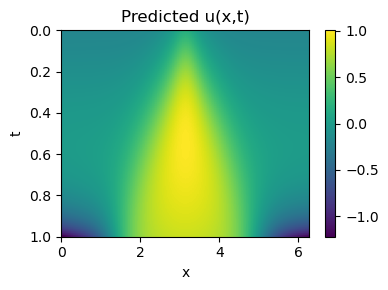

In [7]:
# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

def h(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return h(x) * np.exp(5*t) / ( h(x) * np.exp(5*t) + 1 - h(x))

res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)
u = u_ana(res_test[:,0], res_test[:,1]).reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_pinnsformer_pred.png')
plt.show()

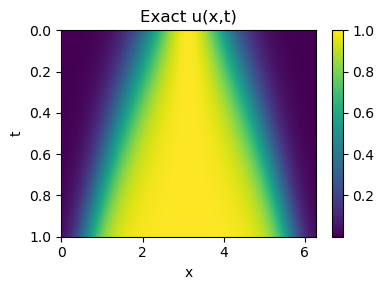

In [8]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_exact.png')
plt.show()

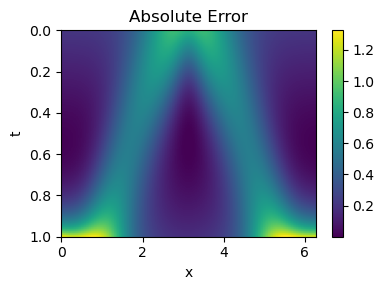

In [9]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_pinnsformer_error.png')
plt.show()